# Loading Pre-Trained Models

## Description



在本教程中，我们将使用[ModelZoo](https://github.com/caffe2/caffe2/wiki/Model-Zoo) 中预先训练的`squeezenet`模型对我们自己的图像进行分类。作为输入，我们将为要分类的图像提供路径（或URL）。了解图像的[ImageNet目标代码](https://gist.githubusercontent.com/aaronmarkham/cd3a6b6ac071eca6f7b4a6e40e6038aa/raw/9edb4038a37da6b5a44c3b5bc52e448ff09bfe5b/alexnet_codes) 也很有帮助，这样我们就可以验证结果。 '目标代码'只不过是训练期间使用的类的整数标签，例如“985”是类“daisy”(雏菊)的代码。请注意，虽然我们在这里使用squeezenet，但本教程可作为在预训练模型上运行推理的一种通用方法。



如果您来自[图像预处理教程](https://caffe2.ai/docs/tutorial-image-pre-processing.html) ， 您将看到我们正在使用重新缩放和裁剪功能来准备图像，以及将图像重新格式化为CHW，BGR，最后是NCHW。我们还通过使用提供的npy文件中的计算平均值或直接减128作为减平均值来校正图像均值。



希望你会发现加载预训练模型很简单，语法简洁。从较高的层面来看，这些是在预训练模型上运行推理所需的三个步骤：

1. 读取预训练模型的init_net.pb和参数predict_net.pb文件

        with open("init_net.pb", "rb") as f:
            init_net = f.read()
        with open("predict_net.pb", "rb") as f:
            predict_net = f.read()        

2. 使用protobufs中的blob在工作区（workspace）中初始化预测器

        p = workspace.Predictor(init_net, predict_net)

3. Run the net on some data and get the (softmax) results!

        results = p.run({'data': img})


注意，假设网络的最后一层是softmax层，结果返回为多维数组的概率，其长度等于模型训练的类的数量。概率可以由目标代码（整数类型）索引，因此如果您知道目标代码，则可以在该索引处索引结果数组，以查看网络对输入图像属于该类的置信度。

**Model Download Options**

 
虽然我们将在这里使用`squeezenet`，但您可以查看[Model Zoo for pre-trained models](https://github.com/caffe2/caffe2/wiki/Model-Zoo)来浏览/下载各种预训练模型，或者您可以使用Caffe2的`caffe2.python.models.download`模块轻松地从[Github caffe2/models](http://github.com/caffe2/models)获取预训练模型。


为了我们的目的，我们将使用`models.download`模块使用以下命令将`squeezenet`下载到我们本地Caffe2安装的`/caffe2/python/models`文件夹中：

```
python -m caffe2.python.models.download -i squeezenet
```


如果完成上面的下载工作，那么你的`/caffe2/python/models`文件夹中应该有一个名为squeezenet的目录，其中包含`init_net.pb`和`predict_net.pb`。注意，如果你不使用`-i`标志，模型将下载到你的本地文件夹，但它仍然是一个名为squeezenet的目录，包含两个protobuf文件。或者，如果您希望下载所有模型，可以使用以下方法克隆整个仓库：

```
git clone https://github.com/caffe2/models
```

## Code 

在开始之前，让我们来处理所需的imports。

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
%matplotlib inline
from caffe2.proto import caffe2_pb2
import numpy as np
import skimage.io
import skimage.transform
from matplotlib import pyplot
import os
from caffe2.python import core, workspace, models
import urllib2
import operator
print("Required modules imported.")

Required modules imported.


### Inputs

在这里，我们将指定用于此次运行的输入(imports)，包括输入图像，模型位置，image_mean文件（可选），图像所需的大小以及标签映射文件的位置。

In [2]:
# Configuration --- Change to your setup and preferences!
# This directory should contain the models downloaded from the model zoo. To run this 
#   tutorial, make sure there is a 'squeezenet' directory at this location that 
#   contains both the 'init_net.pb' and 'predict_net.pb'

#CAFFE_MODELS = "~/caffe2/caffe2/python/models"
CAFFE_MODELS = "/home/jack/code_jack/caffe2/caffe2_model"

# Some sample images you can try, or use any URL to a regular image.
# IMAGE_LOCATION = "https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Whole-Lemon.jpg/1235px-Whole-Lemon.jpg"
# IMAGE_LOCATION = "https://upload.wikimedia.org/wikipedia/commons/7/7b/Orange-Whole-%26-Split.jpg"
# IMAGE_LOCATION = "https://upload.wikimedia.org/wikipedia/commons/a/ac/Pretzel.jpg"
# IMAGE_LOCATION = "https://cdn.pixabay.com/photo/2015/02/10/21/28/flower-631765_1280.jpg"
IMAGE_LOCATION = "images/flower.jpg"

# What model are we using?
#    Format below is the model's: <folder, INIT_NET, predict_net, mean, input image size>
#    You can switch 'squeezenet' out with 'bvlc_alexnet', 'bvlc_googlenet' or others that you have downloaded
MODEL = 'squeezenet', 'init_net.pb', 'predict_net.pb', 'ilsvrc_2012_mean.npy', 227

# codes - these help decypher the output and source from a list from ImageNet's object codes 
#    to provide an result like "tabby cat" or "lemon" depending on what's in the picture 
#   you submit to the CNN.
codes =  "https://gist.githubusercontent.com/aaronmarkham/cd3a6b6ac071eca6f7b4a6e40e6038aa/raw/9edb4038a37da6b5a44c3b5bc52e448ff09bfe5b/alexnet_codes"
print("Config set!")

Config set!


### Setup paths


设置配置后，我们现在可以加载image_mean文件（如果存在），以及预测网络和init网络。

In [3]:
# set paths and variables from model choice and prep image
CAFFE_MODELS = os.path.expanduser(CAFFE_MODELS)

# mean can be 128 or custom based on the model
# gives better results to remove the colors found in all of the training images
MEAN_FILE = os.path.join(CAFFE_MODELS, MODEL[0], MODEL[3])
if not os.path.exists(MEAN_FILE):
    print("No mean file found!")
    mean = 128
else:
    print ("Mean file found!")
    mean = np.load(MEAN_FILE).mean(1).mean(1)
    mean = mean[:, np.newaxis, np.newaxis]
print("mean was set to: ", mean)

# some models were trained with different image sizes, this helps you calibrate(校准) your image
INPUT_IMAGE_SIZE = MODEL[4]

# make sure all of the files are around...
INIT_NET = os.path.join(CAFFE_MODELS, MODEL[0], MODEL[1])
PREDICT_NET = os.path.join(CAFFE_MODELS, MODEL[0], MODEL[2])

# Check to see if the files exist
if not os.path.exists(INIT_NET):
    print("WARNING: " + INIT_NET + " not found!")
else:
    if not os.path.exists(PREDICT_NET):
        print("WARNING: " + PREDICT_NET + " not found!")
    else:
        print("All needed files found!")
        

No mean file found!
mean was set to:  128
All needed files found!


### Image Preprocessing


现在我们已经指定了输入并验证了输入网络的存在，我们可以加载图像并预处理图像以供提取到Caffe2卷积神经网络中！这是非常重要的一步，因为训练有素的CNN需要特定大小的输入图像，其值来自特定分布。

Original Image Shape:  (751, 1280, 3)
Image Shape after rescaling:  (227, 386, 3)


/home/jack/anaconda2/envs/caffe2/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/jack/anaconda2/envs/caffe2/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Image Shape after cropping:  (227, 227, 3)
CHW Image Shape:  (3, 227, 227)
NCHW image (ready to be used as input):  (1, 3, 227, 227)


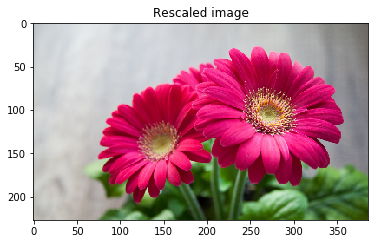

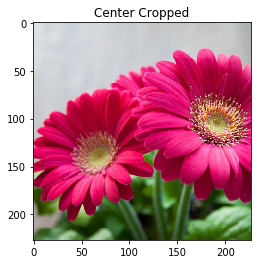

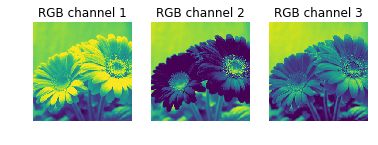

In [5]:
# Function to crop the center cropX x cropY pixels from the input image
def crop_center(img,cropx,cropy):
    y,x,c = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

# Function to rescale the input image to the desired height and/or width. This function will preserve
#   the aspect ratio of the original image while making the image the correct scale so we can retrieve
#   a good center crop. This function is best used with center crop to resize any size input images into
#   specific sized images that our model can use.
def rescale(img, input_height, input_width):
    # Get original aspect ratio
    aspect = img.shape[1]/float(img.shape[0])
    if(aspect>1):
        # landscape orientation - wide image
        res = int(aspect * input_height)
        imgScaled = skimage.transform.resize(img, (input_width, res))
    if(aspect<1):
        # portrait orientation - tall image
        res = int(input_width/aspect)
        imgScaled = skimage.transform.resize(img, (res, input_height))
    if(aspect == 1):
        imgScaled = skimage.transform.resize(img, (input_width, input_height))
    return imgScaled

# Load the image as a 32-bit float
#    Note: skimage.io.imread returns a HWC ordered RGB image of some size
img = skimage.img_as_float(skimage.io.imread(IMAGE_LOCATION)).astype(np.float32)
print("Original Image Shape: " , img.shape)

# Rescale the image to comply with our desired input size. This will not make the image 227x227
#    but it will make either the height or width 227 so we can get the ideal center crop.
img = rescale(img, INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)
print("Image Shape after rescaling: " , img.shape)
pyplot.figure()
pyplot.imshow(img)
pyplot.title('Rescaled image')

# Crop the center 227x227 pixels of the image so we can feed it to our model
img = crop_center(img, INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)
print("Image Shape after cropping: " , img.shape)
pyplot.figure()
pyplot.imshow(img)
pyplot.title('Center Cropped')

# switch to CHW (HWC --> CHW)
img = img.swapaxes(1, 2).swapaxes(0, 1)
print("CHW Image Shape: " , img.shape)

pyplot.figure()
for i in range(3):
    # For some reason, pyplot subplot follows Matlab's indexing
    # convention (starting with 1). Well, we'll just follow it...
    pyplot.subplot(1, 3, i+1)
    pyplot.imshow(img[i])
    pyplot.axis('off')
    pyplot.title('RGB channel %d' % (i+1))

# switch to BGR (RGB --> BGR)
img = img[(2, 1, 0), :, :]

# remove mean for better results
img = img * 255 - mean

# add batch size axis which completes the formation of the NCHW shaped input that we want
img = img[np.newaxis, :, :, :].astype(np.float32)

print("NCHW image (ready to be used as input): ", img.shape)

### Prepare the CNN and run the net!


既然图像已准备好被CNN提取，让我们打开protobufs文件，将它们加载到工作区中，然后运行网络。

In [7]:
# Read the contents of the input protobufs into local variables
#将输入的protobufs的内容读入局部变量
with open(INIT_NET, "rb") as f:
    init_net = f.read()
with open(PREDICT_NET, "rb") as f:
    predict_net = f.read()

# Initialize the predictor from the input protobufs
p = workspace.Predictor(init_net, predict_net)

# Run the net and return prediction
results = p.run({'data': img})

# Turn it into something we can play with and examine which is in a multi-dimensional array
#把它变成我们可以观察的东西，并检查哪个是多维数组
results = np.asarray(results)
print("results shape: ", results.shape)

# Quick way to get the top-1 prediction result
# Squeeze out the unnecessary axis. This returns a 1-D array of length 1000
# 挤出不必要的轴。这将返回长度为1000的1-D数组
preds = np.squeeze(results)
# Get the prediction and the confidence by finding the maximum value and index of maximum value in preds array
#通过在preds数组中找到最大值和最大值索引来获得预测和置信度
curr_pred, curr_conf = max(enumerate(preds), key=operator.itemgetter(1))
print("Prediction: ", curr_pred)
print("Confidence: ", curr_conf)

results shape:  (1, 1, 1000, 1, 1)
Prediction:  985
Confidence:  0.982227


### Process Results


召回ImageNet是一个1000类数据集，并观察到第三个结果轴长度为1000并非巧合。该轴保留了预训练模型中每个类别的概率。因此，当您在特定索引处查看结果数组时，该数字可以解释为输入属于与该索引对应的类的概率。现在我们已经运行了预测器并收集了结果，我们可以通过将它们与相应的英文标签相匹配来解释它们。

In [8]:
# the rest of this is digging through the results 
# 剩下的就是挖掘结果
results = np.delete(results, 1)
index = 0
highest = 0
arr = np.empty((0,2), dtype=object)
arr[:,0] = int(10)
arr[:,1:] = float(10)
for i, r in enumerate(results):
    # imagenet index begins with 1!
    i=i+1
    arr = np.append(arr, np.array([[i,r]]), axis=0)
    if (r > highest):
        highest = r
        index = i 

# top N results
N = 5
topN = sorted(arr, key=lambda x: x[1], reverse=True)[:N]
print("Raw top {} results: {}".format(N,topN))

# Isolate the indexes of the top-N most likely classes
# 隔离前N个最有可能的类的索引
topN_inds = [int(x[0]) for x in topN]
print("Top {} classes in order: {}".format(N,topN_inds))

# Now we can grab the code list and create a class Look Up Table
# 现在我们可以获取代码列表并创建一个查找表类
response = urllib2.urlopen(codes)
class_LUT = []
for line in response:
    code, result = line.partition(":")[::2]
    code = code.strip()
    result = result.replace("'", "")
    if code.isdigit():
        class_LUT.append(result.split(",")[0][1:])
        
# For each of the top-N results, associate the integer result with an actual class
# 对于每个前N个结果，将整数结果与实际类相关联
for n in topN:
    print("Model predicts '{}' with {}% confidence".format(class_LUT[int(n[0])],float("{0:.2f}".format(n[1]*100))))


Raw top 5 results: [array([985.0, 0.9822270274162292], dtype=object), array([309.0, 0.011943656019866467], dtype=object), array([946.0, 0.004810133948922157], dtype=object), array([325.0, 0.00034070576657541096], dtype=object), array([944.0, 0.00023906580463517457], dtype=object)]
Top 5 classes in order: [985, 309, 946, 325, 944]
Model predicts 'daisy' with 98.22% confidence
Model predicts 'bee' with 1.19% confidence
Model predicts 'cardoon' with 0.48% confidence
Model predicts 'sulphur butterfly' with 0.03% confidence
Model predicts 'artichoke' with 0.02% confidence


### Feeding Larger Batches（喂养更大的批次）


以上是如何一个批次（batch）送入一个图像的示例。如果我们在一个批次中一次提供多个图像，我们可以实现更高的吞吐量。回想一下，输入分类器的数据是'NCHW'顺序，因此为了提供多个图像，我们将扩展'N'轴。

In [9]:
# List of input images to be fed
images = ["images/cowboy-hat.jpg",
            "images/cell-tower.jpg",
            "images/Ducreux.jpg",
            "images/pretzel.jpg",
            "images/orangutan.jpg",
            "images/aircraft-carrier.jpg",
            "images/cat.jpg"]

# Allocate space for the batch of formatted images
# 为批量格式化的图像分配空间
NCHW_batch = np.zeros((len(images),3,227,227))
print ("Batch Shape: ",NCHW_batch.shape)

# For each of the images in the list, format it and place it in the batch
# 对于列表中的每个图像，对其进行格式化并将其放入批处理中
for i,curr_img in enumerate(images):
    img = skimage.img_as_float(skimage.io.imread(curr_img)).astype(np.float32)
    img = rescale(img, 227, 227)
    img = crop_center(img, 227, 227)
    img = img.swapaxes(1, 2).swapaxes(0, 1)
    img = img[(2, 1, 0), :, :]
    img = img * 255 - mean
    NCHW_batch[i] = img

print("NCHW image (ready to be used as input): ", NCHW_batch.shape)

# Run the net on the batch
results = p.run([NCHW_batch.astype(np.float32)])

# Turn it into something we can play with and examine which is in a multi-dimensional array
#把它变成我们可以观察的东西，并检查哪个是多维数组
results = np.asarray(results)

# Squeeze out the unnecessary axis
# 挤出不必要的轴
preds = np.squeeze(results)
print("Squeezed Predictions Shape, with batch size {}: {}".format(len(images),preds.shape))

# Describe the results
for i,pred in enumerate(preds):
    print("Results for: '{}'".format(images[i]))
    # Get the prediction and the confidence by finding the maximum value and index of maximum value in preds array
    # 通过在preds数组中找到最大值和最大值索引来获得预测和置信度
    curr_pred, curr_conf = max(enumerate(pred), key=operator.itemgetter(1))
    print("\tPrediction: ", curr_pred)
    print("\tClass Name: ", class_LUT[int(curr_pred)])
    print("\tConfidence: ", curr_conf)

Batch Shape:  (7, 3, 227, 227)
NCHW image (ready to be used as input):  (7, 3, 227, 227)
Squeezed Predictions Shape, with batch size 7: (7, 1000)
Results for: 'images/cowboy-hat.jpg'
	Prediction:  515
	Class Name:  cowboy hat
	Confidence:  0.8500917
Results for: 'images/cell-tower.jpg'
	Prediction:  645
	Class Name:  maypole
	Confidence:  0.18584356
Results for: 'images/Ducreux.jpg'
	Prediction:  568
	Class Name:  fur coat
	Confidence:  0.10253135
Results for: 'images/pretzel.jpg'
	Prediction:  932
	Class Name:  pretzel
	Confidence:  0.99962187
Results for: 'images/orangutan.jpg'
	Prediction:  365
	Class Name:  orangutan
	Confidence:  0.9920053
Results for: 'images/aircraft-carrier.jpg'
	Prediction:  403
	Class Name:  aircraft carrier
	Confidence:  0.9998778
Results for: 'images/cat.jpg'
	Prediction:  281
	Class Name:  tabby
	Confidence:  0.5133174
